In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_addons as tfa 
from tqdm.notebook import tqdm
import multiprocessing

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
np.set_printoptions(suppress=True)

In [2]:
def compute_gaussian_peak(x, A, loc, scale, asymmetry=None, eps=1e-7):
    if asymmetry is None:
        return A * np.exp((-(x - loc)**2) / (2 * scale**2))
    return A * np.exp(-1/2*((x - loc)/(eps + scale + asymmetry * (x - loc)))**2)

def apply_white_noise(x, A, snr, random_seed):
    np.random.seed(random_seed)
    stddev = A.mean() / snr / 4 # approximately noise levels that match snr
    noise = np.random.normal(0, stddev, len(x))
    return x + noise

def apply_pink_noise(x, A, snr, num_sources, random_seed):
    np.random.seed(random_seed)
    nrows = len(x)
    ncols = num_sources

    noise = np.full((nrows, ncols), np.nan)
    noise[0, :] = np.random.random(ncols)
    noise[:, 0] = np.random.random(nrows)

    cols = np.random.geometric(0.5, nrows)
    cols[cols >= ncols] = 0
    rows = np.random.randint(nrows, size=nrows)
    noise[rows, cols] = np.random.random(nrows)

    noise = pd.DataFrame(noise)
    noise.fillna(method='ffill', axis=0, inplace=True)
    noise = noise.sum(axis=1).to_numpy()
    noise = (noise - noise.mean())
    noise = (A.mean()/snr) * noise / 2 # approximately noise levels that match snr
    return noise + x

def apply_drift(x, resolution, random_seed):
    np.random.seed(random_seed)
    def sigmoidal(y, m, w, b):
        return 1 / (1 + np.exp( - (y * w + b) )) * m
    y = np.linspace(-1, 1, resolution)
    drift = np.zeros(resolution, dtype='float32')
    n = 10
    for _ in range(n):
        h = np.random.uniform(-500, 500)  
        w = np.random.uniform(-20, 20)
        b = np.random.uniform(-20, 20)
        drift += sigmoidal(y, h, w, b) / n
    return x + drift

In [3]:

class Simulator:

    def __init__(self,
                 resolution,
                 num_peaks_range,
                 snr_range,
                 A_range,
                 loc_range,
                 scale_range,
                 asymmetry_range,
                 pink_noise_prob):

        self.x = np.linspace(0, 1, resolution)
        self.resolution = resolution
        self.num_peaks_range = num_peaks_range
        self.snr_range = snr_range
        self.A_range = A_range
        self.loc_range = loc_range
        self.scale_range = scale_range
        self.asymmetry_range = asymmetry_range
        self.pink_noise_prob = pink_noise_prob

    def run(self, random_seed):

        np.random.seed(random_seed)
        
        # Randomly obtain parameters of the peaks
        self.num_peaks = np.random.randint(*self.num_peaks_range)
        self.A = np.random.uniform(*self.A_range, size=(self.num_peaks,))
        self.loc = np.random.uniform(*self.loc_range, size=(self.num_peaks,))
        self.scale = np.random.uniform(*self.scale_range, size=(self.num_peaks,))
        
        # Obtain asymmetry if not None (i.e. peak fronting/tailing)
        if self.asymmetry_range is not None:
            self.asymmetry = np.random.uniform(*self.asymmetry_range, size=(self.num_peaks,))
        else:
            self.asymmetry = [None]*self.num_peaks
        
        # Generate (noise-free) chromatogram
        chromatogram = np.zeros_like(self.x)
        for a, m, s, t in zip(self.A, self.loc, self.scale, self.asymmetry):
            chromatogram += compute_gaussian_peak(self.x, a, m, s, t)
        
        # Obtain random signal-to-noise ratio (SNR)
        self.snr = np.random.uniform(*self.snr_range)
        
        # Apply pink noise or white noise
        if self.pink_noise_prob > np.random.random():
            chromatogram_noisy = apply_pink_noise(
                chromatogram, self.A, self.snr, 6, random_seed)
        else:
            chromatogram_noisy = apply_white_noise(
                chromatogram, self.A, self.snr, random_seed)
        
        # Apply baseline drift
        chromatogram_noisy_drift = apply_drift(
            chromatogram_noisy, self.resolution, random_seed)

        return (
            chromatogram_noisy_drift[:, None],
            self.loc,
            self.scale,
            self.A
        )
    
simulator = Simulator(
    resolution=8192,
    num_peaks_range=(1, 100),
    snr_range=(1.0, 20.0),
    A_range=(25, 250),
    loc_range=(0.05, 0.95),
    scale_range=(0.001, 0.003),
    asymmetry_range=(-0.1, 0.1),
    pink_noise_prob=0.0,
)

In [4]:
class LabelEncoder:
    
    def __init__(self, num_windows, num_classes=4):
        self.num_windows = num_windows
        self.window_size = 1 / self.num_windows
        self.window_borders = np.linspace(0, 1, self.num_windows+1)
        self.window_centers = self.window_borders[1:] - self.window_size / 2
        self.num_classes = num_classes
        
    def encode(self, locs, scales, amplitudes):
        labels = np.zeros((self.num_windows, self.num_classes))
        for loc, scale, amplitude in zip(locs, scales, amplitudes):
            
            # Obtain location in window (local scale)
            distance = loc - self.window_centers
            index = np.argmin(np.abs(distance))
            loc = 0.5 + distance[index] / self.window_size
            # Obtain width in window (local scale)
            width = (scale * 4) / self.window_size # the width is defined as four stddevs
            
            # Add prob (= 1), loc, width and amplitude to labels
            labels[index, 0] = 1.
            labels[index, 1] = loc
            labels[index, 2] = width
            labels[index, 3] = amplitude
        
        return labels
            
    def decode(self, predictions, threshold=0.5):
        
        # Unpack predictions: (N, num_classes) -> (N,) * num_classes
        probs, locs, widths, amplitudes = [
            split[:, 0] for split in np.split(predictions, self.num_classes, axis=-1)
        ]
        # Where probability of peak is above threshold, obtain indices
        indices = np.where(probs > threshold)[0]

        # Transform locs and widths to global scale
        locs = locs[indices] * self.window_size + self.window_borders[indices]
        widths = widths[indices] * self.window_size
        
        return probs[indices], locs, widths, amplitudes[indices]

encoder = LabelEncoder(256)


In [5]:

def generate_example(i):
    
    chromatogram, locs, scales, amplitudes = simulator.run(i)
    return chromatogram, encoder.encode(locs, scales, amplitudes)

with multiprocessing.Pool() as pool:
    examples = [i for i in tqdm(pool.imap(generate_example, range(30_000)), total=30_000)]
    
x = np.stack([example[0] for example in examples], axis=0)
y = np.stack([example[1] for example in examples], axis=0)


x_train, y_train = x[:28000], y[:28000]
x_validation, y_validation = x[28000:29000], y[28000:29000]
x_test, y_test = x[29000:], y[29000:]
t = np.linspace(0, 1, 8192)


In [7]:

class MixedLoss(tf.keras.losses.Loss):
    
    def __init__(
        self, 
        weight_prob=1.0, 
        weight_loc=1.0, 
        weight_width=1.0, 
        weight_amplitude=1.0, 
        **kwargs
    ):
        super().__init__(**kwargs)
        
        self.weight_prob = weight_prob
        self.weight_loc = weight_loc
        self.weight_width = weight_width
        self.weight_amplitude = weight_amplitude

    def call(self, y_true, y_pred, sample_weight=None):
        
        # Cast to dtype float32 just in case
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        
        # Unpack trues and preds
        pred_prob, pred_loc, pred_width, pred_amplitude = tf.split(y_pred, 4, axis=-1)
        true_prob, true_loc, true_width, true_amplitude = tf.split(y_true, 4, axis=-1)

        # Mask for where y_true is indicating a peak
        mask = tf.math.equal(true_prob, 1.)
        
        # Compute loss for all instances
        bce_loss_1 = tf.keras.losses.BinaryCrossentropy()(true_prob, pred_prob)
        # Compute loss only for instances in mask
        bce_loss_2 = tf.keras.losses.BinaryCrossentropy()(
            tf.boolean_mask(true_loc, mask), tf.boolean_mask(pred_loc, mask))
        # Compute loss only for instances in mask
        huber_loss_1 = tf.keras.losses.Huber()(
            tf.boolean_mask(true_width, mask), tf.boolean_mask(pred_width, mask))
        
        huber_loss_2 = tf.keras.losses.Huber()(
            tf.boolean_mask(true_amplitude, mask), tf.boolean_mask(pred_amplitude, mask))
        
        return (
            bce_loss_1 * self.weight_prob + 
            bce_loss_2 * self.weight_loc + 
            huber_loss_1 * self.weight_width +
            huber_loss_2 * self.weight_amplitude
        )


class SelectiveActivation(tf.keras.layers.Layer):
    
    def __init__(self, input_dim, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
    
    def call(self, inputs):
        pred, loc, scale, amplitude = tf.split(inputs, self.input_dim, axis=-1)
        pred = tf.nn.sigmoid(pred)
        loc = tf.nn.sigmoid(loc)
        return tf.concat([pred, loc, scale, amplitude], axis=-1)
    

In [8]:


def get_model(
    filters=[64, 128, 128, 256, 256], 
    kernel_sizes=[9, 9, 9, 9, 9], 
    pool_type='max',
    input_shape=(8192, 1), 
    output_shape=(256, 4)
):
        
    if input_shape[0] % output_shape[0] != 0:
        raise ValueError("Input length is not a multiple of output length: " +
                         f"{input_shape[0]} vs. {output_shape[0]}")
    
    if pool_type.startswith('max'):
        Pool1D = tf.keras.layers.MaxPool1D
    elif pool_type.startswith(('mean', 'average', 'avg')):
        Pool1D = tf.keras.layers.AveragePool1D
    else:
        raise ValueError(f"'{pool_type}' not available, select either of: " +
                          "'max'/'maximum' or 'mean'/'average'/'avg'")
    
    inputs = tf.keras.layers.Input(input_shape)
    
    x = inputs
    for filt, kernel_size in zip(filters, kernel_sizes):
        x = tf.keras.layers.Conv1D(filt, kernel_size, strides=1, padding='same')(x)
        x = Pool1D()(x)
        
        if x.shape[1] < output_shape[0]:
            raise ValueError("Length of downstream feature maps is smaller " + 
                             f"than the output length: {x.shape[1]} vs. {output_shape[0]}. " +
                             "To fix this, reduce the number of layers.")
        
        
    x = tf.keras.layers.Conv1D(output_shape[0], kernel_size=1, strides=1)(x)
    x = tf.keras.layers.Conv1D(output_shape[1], kernel_size=1, strides=1)(x)
    
    outputs = SelectiveActivation(output_shape[1])(x)

    return tf.keras.Model(inputs=inputs, outputs=outputs)
    
    
model = get_model()
model.compile(loss=MixedLoss(1.0, 1.0, 1.0, 1.0), optimizer=tf.keras.optimizers.Adam(1e-3))
model.fit(x_train, y_train, epochs=10, verbose=1)

Epoch 1/10
875/875 [==============================] - 44s 46ms/step - loss: 21.9686
Epoch 2/10
875/875 [==============================] - 41s 47ms/step - loss: 0.8726
Epoch 3/10
875/875 [==============================] - 43s 49ms/step - loss: 0.8407
Epoch 4/10
875/875 [==============================] - 43s 49ms/step - loss: 0.8280
Epoch 5/10
875/875 [==============================] - 43s 49ms/step - loss: 0.8226
Epoch 6/10
875/875 [==============================] - 44s 50ms/step - loss: 0.8201
Epoch 7/10
177/875 [=====>........................] - ETA: 34s - loss: 0.8188

KeyboardInterrupt: 

(0.45, 0.6)

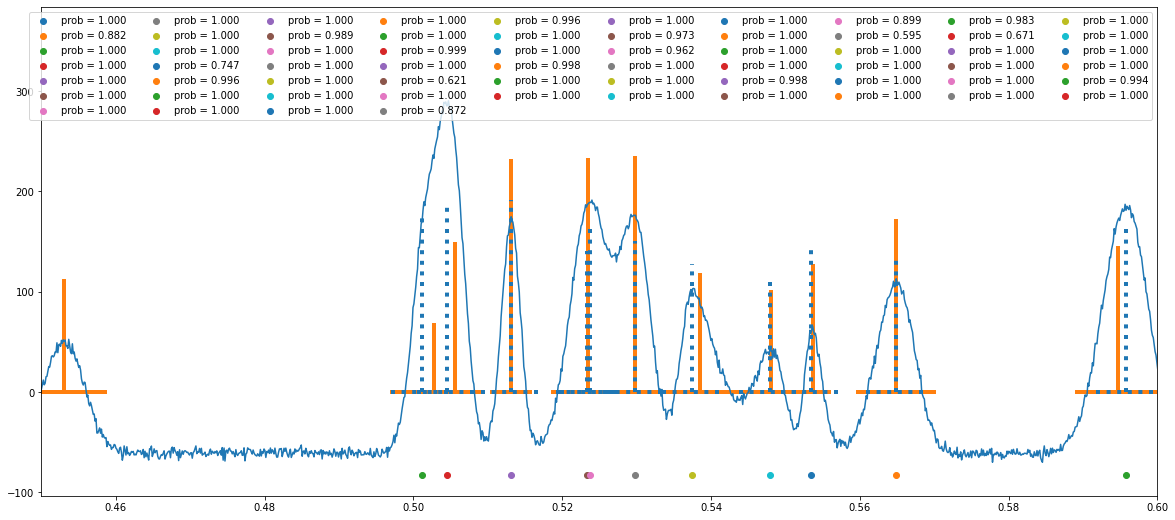

In [9]:
plt.figure(figsize=(20, 9))
#plt.ylim(-.2, 1.15)

ID = 1

# GROUND TRUTH
gt = encoder.decode(y_validation[ID])
for i, (l, s, a) in enumerate(zip(gt[1], gt[2], gt[3])):
    if i == 0:
        label = 'Ground truths'
    else:
        label = None
    #plt.axvline(l, color='black', linestyle=':', label=label)
    plt.plot([l, l], [0, a], color='C1', linewidth=4)
    plt.plot([l-s/2, l+s/2], [0, 0], color='C1', linewidth=4)

# PREDICTIONS
prediction = model.predict(x_validation[ID][None])[0]
probs, locs, scales, amplitudes = encoder.decode(prediction, 0.5) # prob, loc, scale, amplitude

for i, (p, l, w, a) in enumerate(zip(probs, locs, scales, amplitudes)):
    plt.scatter(l, min(x_validation[ID])-10, label=f'prob = {p:.3f}', c=f'C{i}')
    #plt.plot([l-w/2, l+w/2], [.080+(i*.015), .080+(i*.015)], color=f'C{i}')
    #print(a)
    plt.plot([l, l], [0, a], color='C0', linewidth=4, linestyle=':')
    plt.plot([l-s/2, l+s/2], [0, 0], color='C0', linewidth=4, linestyle=':')
    
# CHROMATOGRAM
plt.plot(t, x_validation[ID])


plt.ylim(None, max(x_validation[ID])+60)
plt.legend(ncol=10)

plt.xlim(0.45, 0.6)
# for i, _ in enumerate(np.linspace(0, 1, 257)):
#     plt.axvline(_, ymin=0.0, ymax=0.1, color='grey', alpha=0.8)
#     plt.text(x = _ + 0.002, y=min(X[ID])*1.2, s=i)
    
#plt.savefig(f'pd_{ID}.png', dpi=300)

In [62]:
class TemperatureSoftmaxCalibration(tf.keras.Model):
    
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.temperature = tf.Variable(1., trainable=True)
    
    def call(self, inputs):
        z = inputs / self.temperature
        p = tf.nn.sigmoid(z)
        return p
    
# class TemperatureSoftmaxCalibration(tf.keras.Model):
    
#     def __init__(self, **kwargs):
#         super().__init__(**kwargs)
#         self.a = tf.Variable(1., trainable=True)
#         self.b = tf.Variable(0., trainable=True)
    
#     def call(self, inputs):
#         z = self.a * inputs + self.b
#         p = tf.nn.sigmoid(z)
#         return p
    
calib = TemperatureSoftmaxCalibration()

calib.compile(loss='bce', optimizer=tf.keras.optimizers.Adam(1e-2))

predictions = model.predict(x_validation)

preds = predictions[:, :, 0]
preds = tf.math.log(preds/(1-preds+1e-7))

trues = y_validation[:, :, 0],

calib.fit(preds, trues, epochs=100, verbose=2)

Epoch 1/100
32/32 - 0s - loss: 0.0744
Epoch 2/100
32/32 - 0s - loss: 0.0744
Epoch 3/100
32/32 - 0s - loss: 0.0744
Epoch 4/100
32/32 - 0s - loss: 0.0744
Epoch 5/100
32/32 - 0s - loss: 0.0744
Epoch 6/100
32/32 - 0s - loss: 0.0744
Epoch 7/100
32/32 - 0s - loss: 0.0744
Epoch 8/100
32/32 - 0s - loss: 0.0744
Epoch 9/100
32/32 - 0s - loss: 0.0744
Epoch 10/100
32/32 - 0s - loss: 0.0744
Epoch 11/100
32/32 - 0s - loss: 0.0744
Epoch 12/100
32/32 - 0s - loss: 0.0744
Epoch 13/100
32/32 - 0s - loss: 0.0744
Epoch 14/100
32/32 - 0s - loss: 0.0744
Epoch 15/100
32/32 - 0s - loss: 0.0744
Epoch 16/100
32/32 - 0s - loss: 0.0744
Epoch 17/100
32/32 - 0s - loss: 0.0744
Epoch 18/100
32/32 - 0s - loss: 0.0744
Epoch 19/100
32/32 - 0s - loss: 0.0744
Epoch 20/100
32/32 - 0s - loss: 0.0744
Epoch 21/100
32/32 - 0s - loss: 0.0744
Epoch 22/100
32/32 - 0s - loss: 0.0744
Epoch 23/100
32/32 - 0s - loss: 0.0744
Epoch 24/100
32/32 - 0s - loss: 0.0744
Epoch 25/100
32/32 - 0s - loss: 0.0744
Epoch 26/100
32/32 - 0s - loss: 0.

In [68]:
a = np.array([0.1, 0.01, 0.02, 0.01, 0.005])**0.5

a / a.sum()

array([0.43416422, 0.13729478, 0.19416414, 0.13729478, 0.09708207])

In [63]:
calib.trainable_weights

[<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.9883287>]

In [64]:
new_preds = calib.predict(preds)
new_preds[0][50:250]

array([0.9999999 , 0.01315162, 0.00089292, 0.02007515, 0.00584528,
       0.00687139, 0.01121641, 0.999027  , 0.00456587, 0.00458048,
       0.00555036, 0.00110206, 0.97817916, 0.9656225 , 0.07587819,
       0.00085719, 0.18936278, 0.9999999 , 0.00890169, 0.00502496,
       0.00666814, 0.00969114, 0.00625463, 0.9926225 , 0.00947756,
       0.0071947 , 0.00452559, 0.01128044, 0.00528503, 0.00898242,
       0.9914322 , 0.08296558, 0.00495082, 0.00774186, 0.00524516,
       0.9473183 , 0.01017711, 0.97146803, 0.99999905, 0.00384132,
       0.00556372, 0.01365208, 0.9999999 , 0.00087566, 0.9999999 ,
       0.07077321, 0.00650791, 0.9999999 , 0.01482556, 0.0004111 ,
       0.0820742 , 0.9999999 , 0.00171471, 0.9999999 , 0.00919203,
       0.0066893 , 0.99999976, 0.03940739, 0.0018126 , 0.04514566,
       0.00239178, 0.7494513 , 0.5612319 , 0.9996743 , 0.00361779,
       0.0107372 , 0.09755078, 0.99999833, 0.00499584, 0.00401576,
       0.0043205 , 0.00038904, 0.00273332, 0.88775706, 0.08973

In [65]:
tf.nn.sigmoid(preds)[0][50:250]

<tf.Tensor: shape=(200,), dtype=float32, numpy=
array([0.9999999 , 0.01382201, 0.00096908, 0.02098755, 0.00620416,
       0.00727907, 0.01181126, 0.99894506, 0.00486058, 0.00487595,
       0.00589481, 0.00119311, 0.97721136, 0.9643066 , 0.07794944,
       0.00093076, 0.19198178, 0.9999999 , 0.00940029, 0.00534316,
       0.00706632, 0.01022336, 0.00663324, 0.9921915 , 0.01000077,
       0.00761733, 0.00481821, 0.01187785, 0.0056163 , 0.00948449,
       0.99094814, 0.08512424, 0.00526527, 0.00818936, 0.00557445,
       0.94560975, 0.0107296 , 0.9703043 , 0.9999988 , 0.00409771,
       0.00590882, 0.01434135, 0.9999999 , 0.00095057, 0.9999999 ,
       0.07277525, 0.00689855, 0.9999999 , 0.01555819, 0.00045024,
       0.08422241, 0.9999999 , 0.00184674, 0.9999999 , 0.0097031 ,
       0.00708847, 0.99999964, 0.04084283, 0.00195089, 0.04670613,
       0.00256582, 0.74704236, 0.5605243 , 0.99964225, 0.00386202,
       0.01131269, 0.09986067, 0.999998  , 0.00531257, 0.00428152,
       0.00460

array([], dtype=float32)

In [28]:
import tensorflow_probability as tfp

tfp.stats.expected_calibration_error(
    num_bins=10, 
    logits=tf.reshape(tf.nn.sigmoid(preds), (-1, 1)), 
    labels_true=tf.cast(tf.reshape(trues, (-1)) > 0.5, 'int32'), 
    labels_predicted=tf.cast(tf.reshape(tf.nn.sigmoid(preds), (-1)) > 0.5, 'int32'),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16732813>

In [22]:
tfp.stats.expected_calibration_error(
    num_bins=10, 
    logits=tf.reshape(new_preds, (-1, 1)), 
    labels_true=tf.cast(tf.reshape(trues, (-1)) > 0.5, 'int32'), 
    labels_predicted=tf.cast(tf.reshape(new_preds, (-1)) > 0.5, 'int32'),
)

<tf.Tensor: shape=(), dtype=float32, numpy=0.16732815>

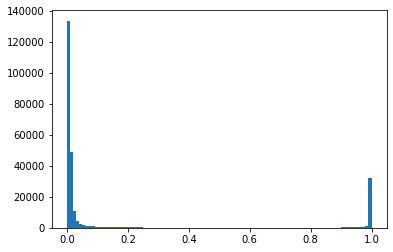

In [26]:
plt.hist(tf.reshape(new_preds, (-1)), bins=100);

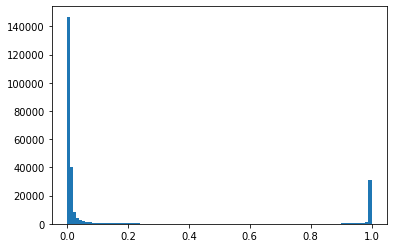

In [29]:
plt.hist(tf.reshape(tf.nn.sigmoid(preds), (-1)), bins=100);